In [99]:
import glob
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import cv2
from tqdm.auto import tqdm
import os
import time
import random
from matplotlib import pyplot as plt
%matplotlib inline

# Downloading data

In [30]:
image_id = "1tW-Zfbhf5FTZavnlSbByO5tgga6PF6qJ"
!gdown 1tW-Zfbhf5FTZavnlSbByO5tgga6PF6qJ

Downloading...
From: https://drive.google.com/uc?id=1tW-Zfbhf5FTZavnlSbByO5tgga6PF6qJ
To: /home/rohanshah/practa/16k_images.zip
100%|████████████████████████████████████████| 400M/400M [02:12<00:00, 3.01MB/s]


In [27]:
!unzip ./16k_images.zip -d data

Archive:  ./20150428_collected_images.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of ./20150428_collected_images.zip or
        ./20150428_collected_images.zip.zip, and cannot find ./20150428_collected_images.zip.ZIP, period.


# Creating embedding from image

In [2]:
def return_image_embedding(model,img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    curr_df = pd.DataFrame(preds[0]).T
    return curr_df
model = ResNet50(include_top=False, weights='imagenet', pooling='avg')

In [40]:
embedding_of_5k = []
img_5k_path = []
cnt = 0
for img_path in tqdm(glob.glob('./data/16k_images/*')):
    embedding_of_5k.append(return_image_embedding(model,img_path))
    img_5k_path.append(os.path.basename(img_path))
    cnt+=1
    if(cnt==5000):
        break

  0%|          | 0/16032 [00:00<?, ?it/s]

# Save Embedding

In [47]:
with open('./embedding_5k.npy', 'wb') as f:
    np.save(f,embedding_of_5k)
    np.save(f, img_5k_path)

# Load Embedding

In [100]:
with open('./embedding_5k.npy', 'rb') as f:
    embedding_5k = np.load(f)
    img_5k = np.load(f)
embedding_5k_copy = embedding_5k

# embedding_df image path and embedding

In [101]:
embedding_df = pd.DataFrame()
for i,curr_img in enumerate(tqdm(img_5k)):
    curr_df = pd.DataFrame(embedding_5k[i][0]).T
    curr_df['image'] = img_5k[i]
    embedding_df = pd.concat([embedding_df,curr_df],ignore_index=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

# finding similar on single image

Original Product:


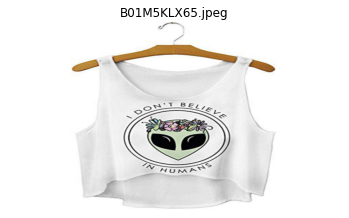

-----------------------------------------------------------------------
Recommended Product


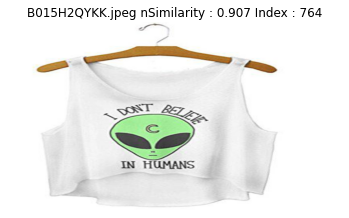

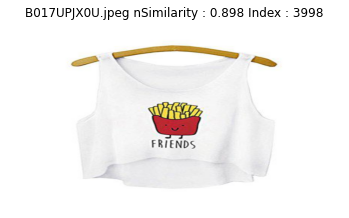

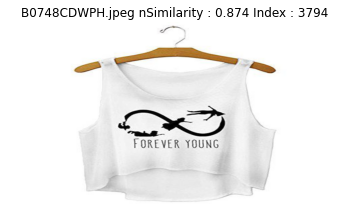

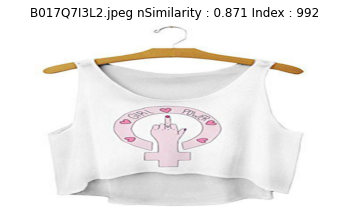

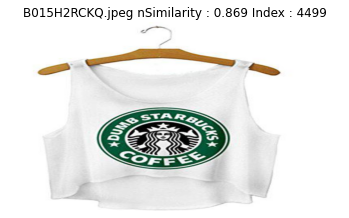

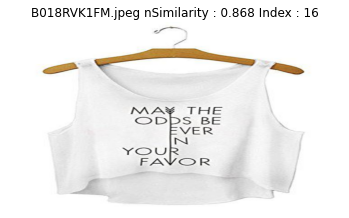

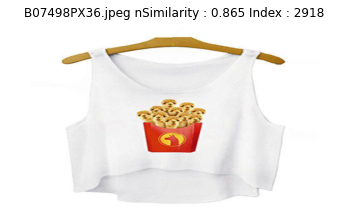

In [102]:
from sklearn.metrics.pairwise import cosine_distances,pairwise_distances,cosine_similarity
cosine_similarity_df = pd.DataFrame(cosine_similarity(embedding_df.drop('image',axis=1)))
cosine_similarity_df_copy = cosine_similarity_df
# np.fill_diagonal(cosine_similarity_df.values, 0)

image_name = img_5k[4000]


def show_img(image_name,title=image_name):
    img_path = './data/16k_images/'+str(image_name)
    im = cv2.imread(img_path)
    im = cv2.resize(im, (960, 540))
    plt.axis('off')
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.show()
    
def fetch_most_similar_products(image_name,n_similar=7):
    print("Original Product:")
    show_img(image_name,image_name)
    curr_index = embedding_df[embedding_df['image']==image_name].index[0]
    closest_image = pd.DataFrame(cosine_similarity_df.iloc[curr_index].nlargest(n_similar+1)[1:])
    print("-----------------------------------------------------------------------")
    print("Recommended Product")
    for index,imgs in closest_image.iterrows():
        similar_image_name = embedding_df.iloc[index]['image']
        similarity = np.round(imgs.iloc[0],3)
        show_img(similar_image_name,str(similar_image_name)+' nSimilarity : '+str(similarity) + ' Index : '+str(index))

fetch_most_similar_products(image_name)


In [103]:
cosine_similarity_df.columns = img_5k
cosine_similarity_df

0         1         2         3         4         5         6     \
0     1.000000  0.492615  0.622776  0.500568  0.586716  0.677132  0.643406   
1     0.492615  1.000001  0.642965  0.489711  0.543110  0.539458  0.429620   
2     0.622776  0.642965  1.000000  0.451398  0.640140  0.689610  0.558860   
3     0.500568  0.489711  0.451398  1.000001  0.486652  0.406714  0.379792   
4     0.586716  0.543110  0.640140  0.486652  1.000000  0.538123  0.433834   
...        ...       ...       ...       ...       ...       ...       ...   
4995  0.644283  0.496908  0.677780  0.420962  0.523404  0.781245  0.791189   
4996  0.614886  0.517253  0.632220  0.488196  0.507106  0.671099  0.794931   
4997  0.689587  0.453334  0.661966  0.346719  0.454542  0.685262  0.677087   
4998  0.475357  0.496105  0.571217  0.439256  0.453201  0.546177  0.523304   
4999  0.644381  0.431703  0.523298  0.419119  0.427414  0.579277  0.686326   

          7         8         9     ...      4990      4991      4992  \
0     0.692864  0.725147  0.697537  ...  0.608804  0.561674  0.376427   
1     0.475443  0.547954  0.558487  ...  0.447024  0.517520  0.456098   
2     0.640889  0.617362  0.710862  ...  0.647981  0.586126  0.380756   
3     0.445227  0.502102  0.430878  ...  0.357016  0.392254  0.459005   
4     0.592639  0.616664  0.635288  ...  0.626415  0.580288  0.354720   
...        ...       ...       ...  ...       ...       ...       ...   
4995  0.699001  0.660986  0.756393  ...  0.685334  0.580987  0.397578   
4996  0.694291  0.698722  0.705465  ...  0.557480  0.567688  0.423277   
4997  0.674316  0.585306  0.607600  ...  0.629358  0.581239  0.355875   
4998  0.540745  0.522592  0.571438  ...  0.488682  0.511327  0.413675   
4999  0.691122  0.631643  0.610523  ...  0.508399  0.539494  0.359412   

          4993      4994      4995      4996      4997      4998      4999  
0     0.487533  0.672104  0.644283  0.614886  0.689587  0.475357  0.644381  
1     0.542326  0.496341  0.496908  0.517253  0.453334  0.496105  0.431703  
2     0.546126  0.642122  0.677780  0.632220  0.661966  0.571217  0.523298  
3     0.474213  0.421741  0.420962  0.488196  0.346719  0.439256  0.419119  
4     0.512757  0.505359  0.523404  0.507106  0.454542  0.453201  0.427414  
...        ...       ...       ...       ...       ...       ...       ...  
4995  0.469357  0.676752  1.000000  0.742906  0.782477  0.596554  0.620799  
4996  0.520967  0.683184  0.742906  1.000000  0.638102  0.596071  0.673890  
4997  0.382011  0.778453  0.782477  0.638102  0.999999  0.476530  0.640696  
4998  0.532380  0.538435  0.596554  0.596071  0.476530  1.000002  0.457059  
4999  0.434646  0.656231  0.620799  0.673890  0.640696  0.457059  1.000000  

[5000 rows x 5000 columns]

# Narrow down using similarity of previously liked,dislike and neutral images

First 3 images using finding cosine similarity(top 3 simiarity).
4th one is random image from Narrow-down-set-of-images.

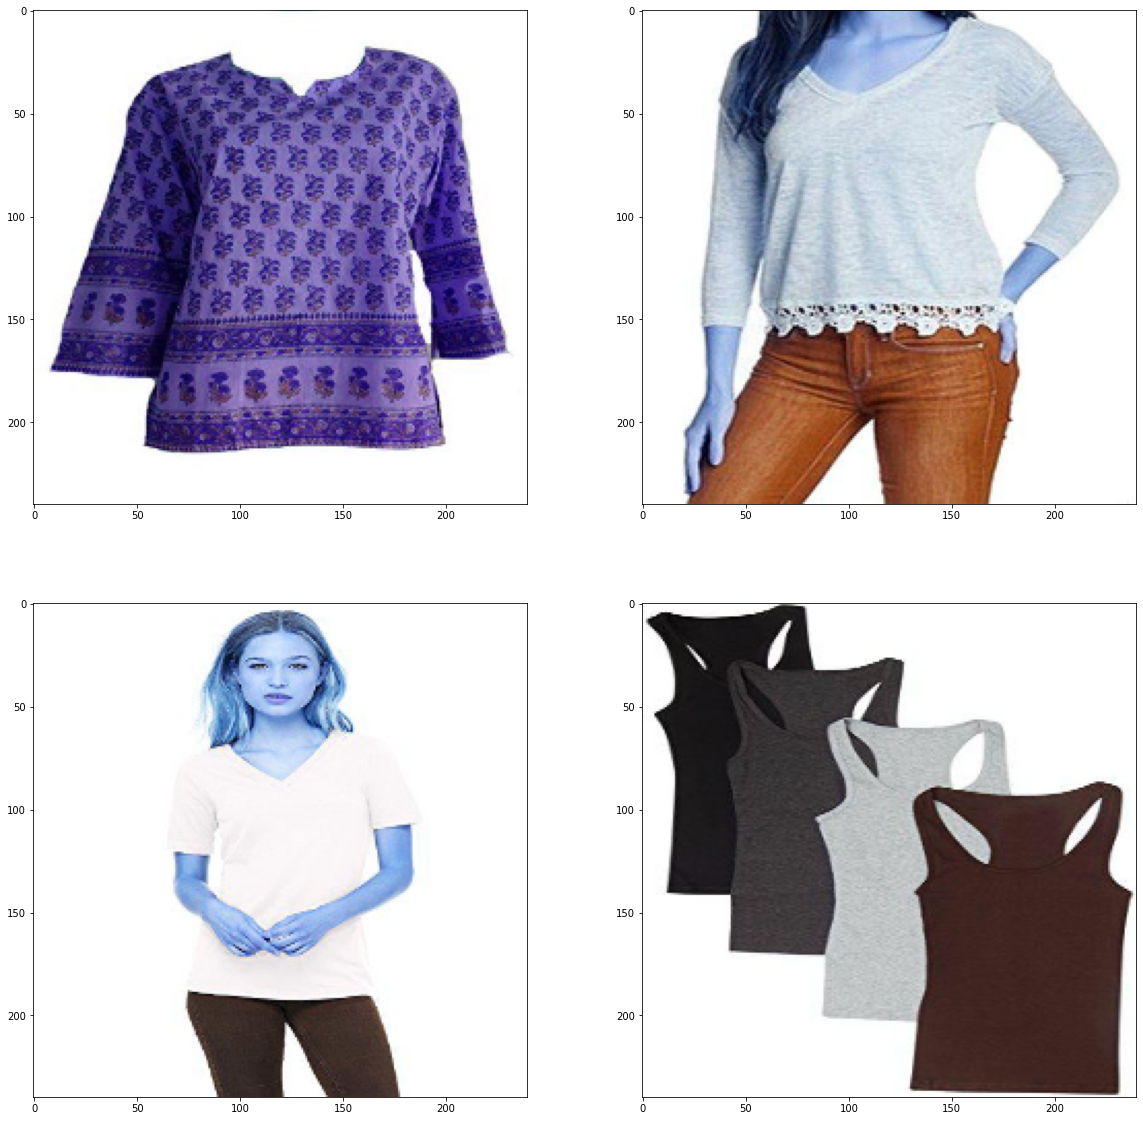

Like = 1 Unlike = 2 Neutral = 3
Image 11
Image 22
Image 32
Image 42
goto next yes(1) no(0)1
-----------------------------------------------------------------------
Recommended Product 2500   compute time 0.039090871810913086
top images 2500


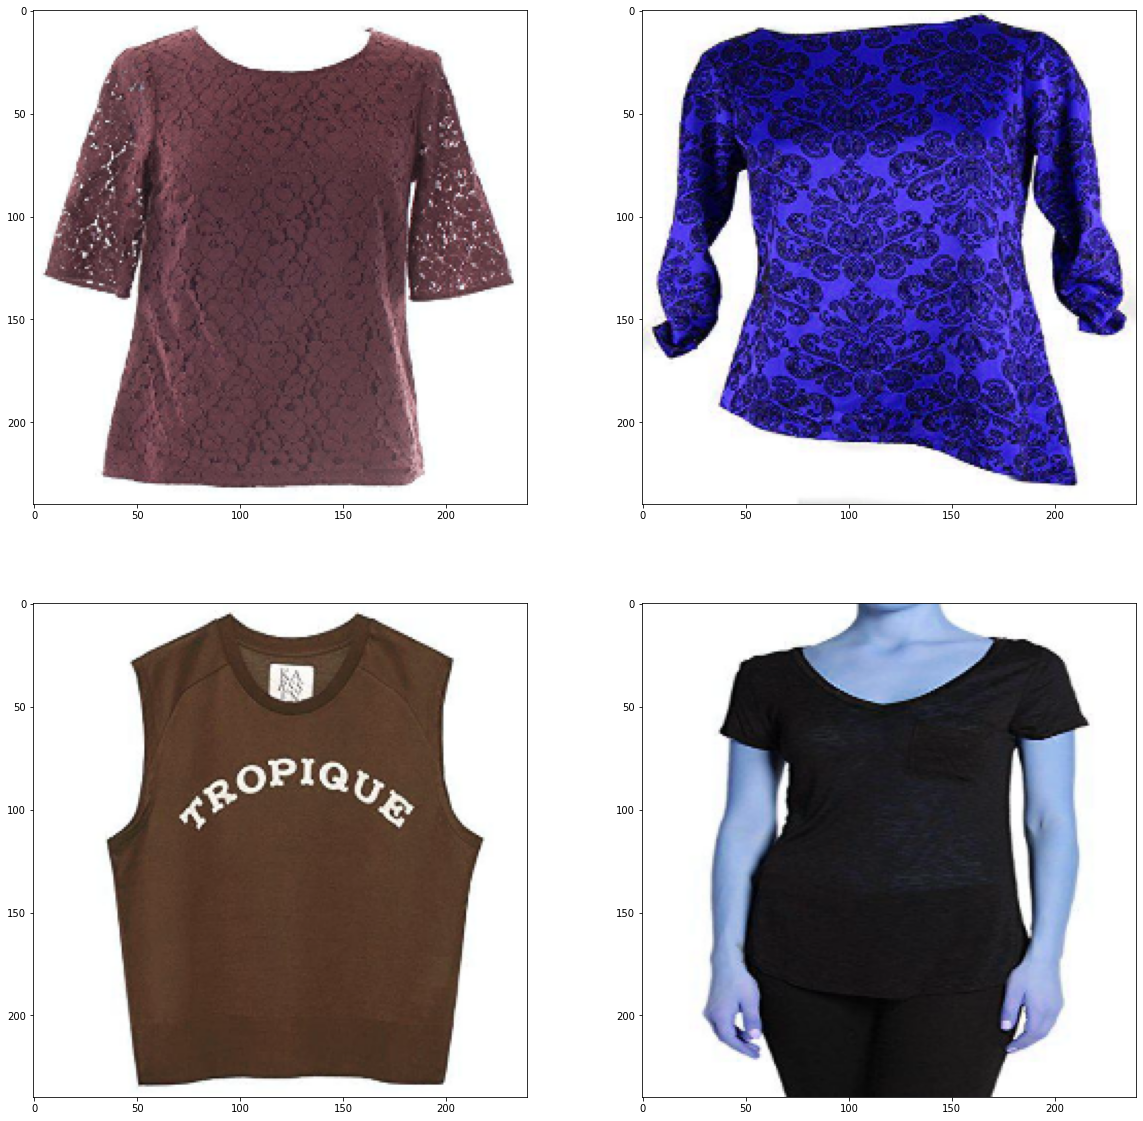

Like = 1 Unlike = 2 Neutral = 3
Image 11
Image 21
Image 32
Image 42
goto next yes(1) no(0)1
-----------------------------------------------------------------------
Recommended Product 1813   compute time 0.030012845993041992
top images 1250


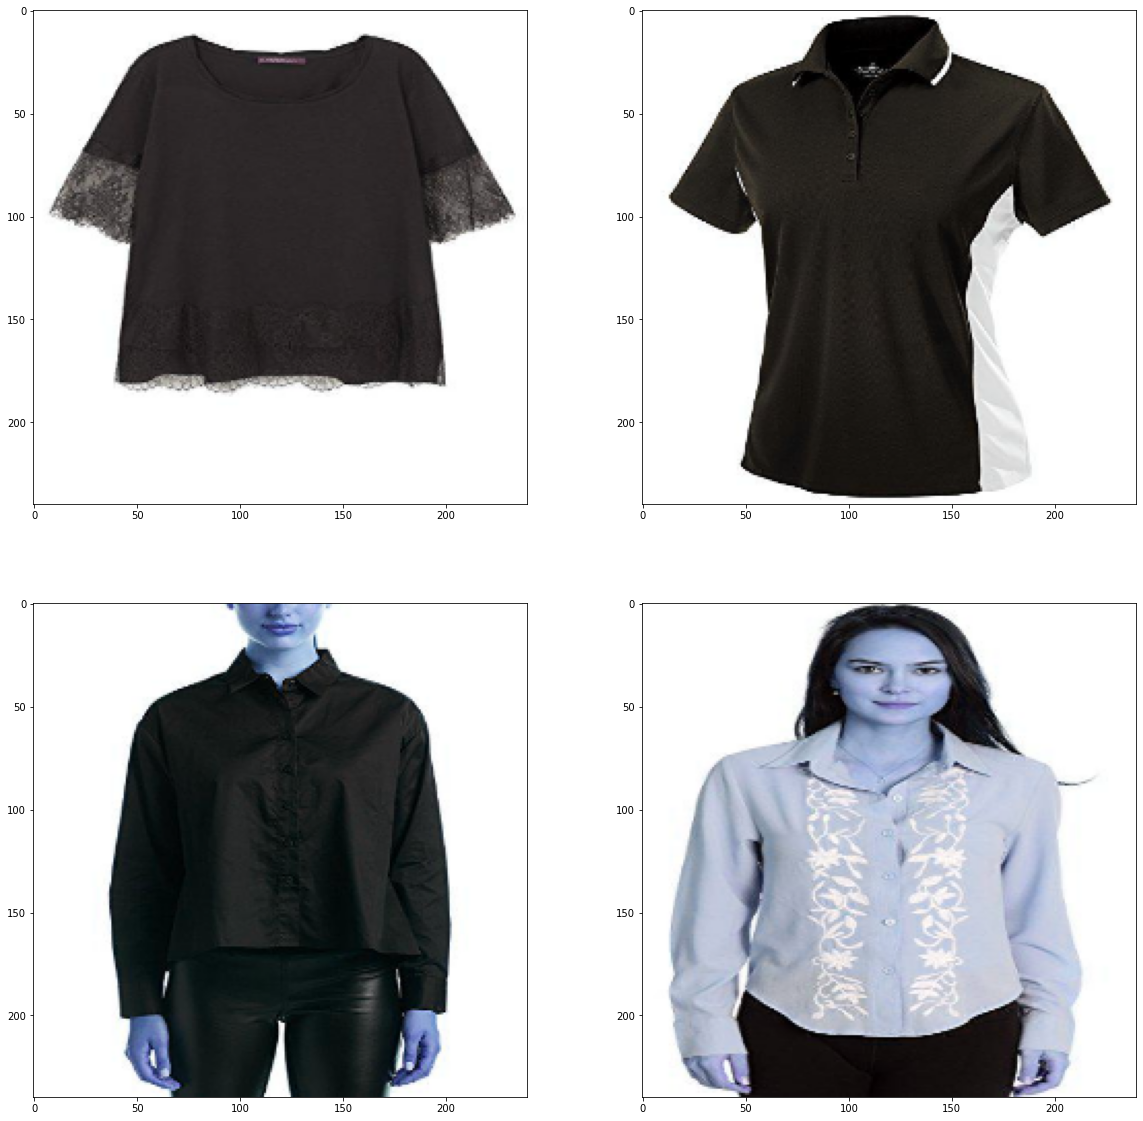

Like = 1 Unlike = 2 Neutral = 3
Image 11
Image 22
Image 31
Image 43
goto next yes(1) no(0)1
-----------------------------------------------------------------------
Recommended Product 1290   compute time 0.029341697692871094
top images 906


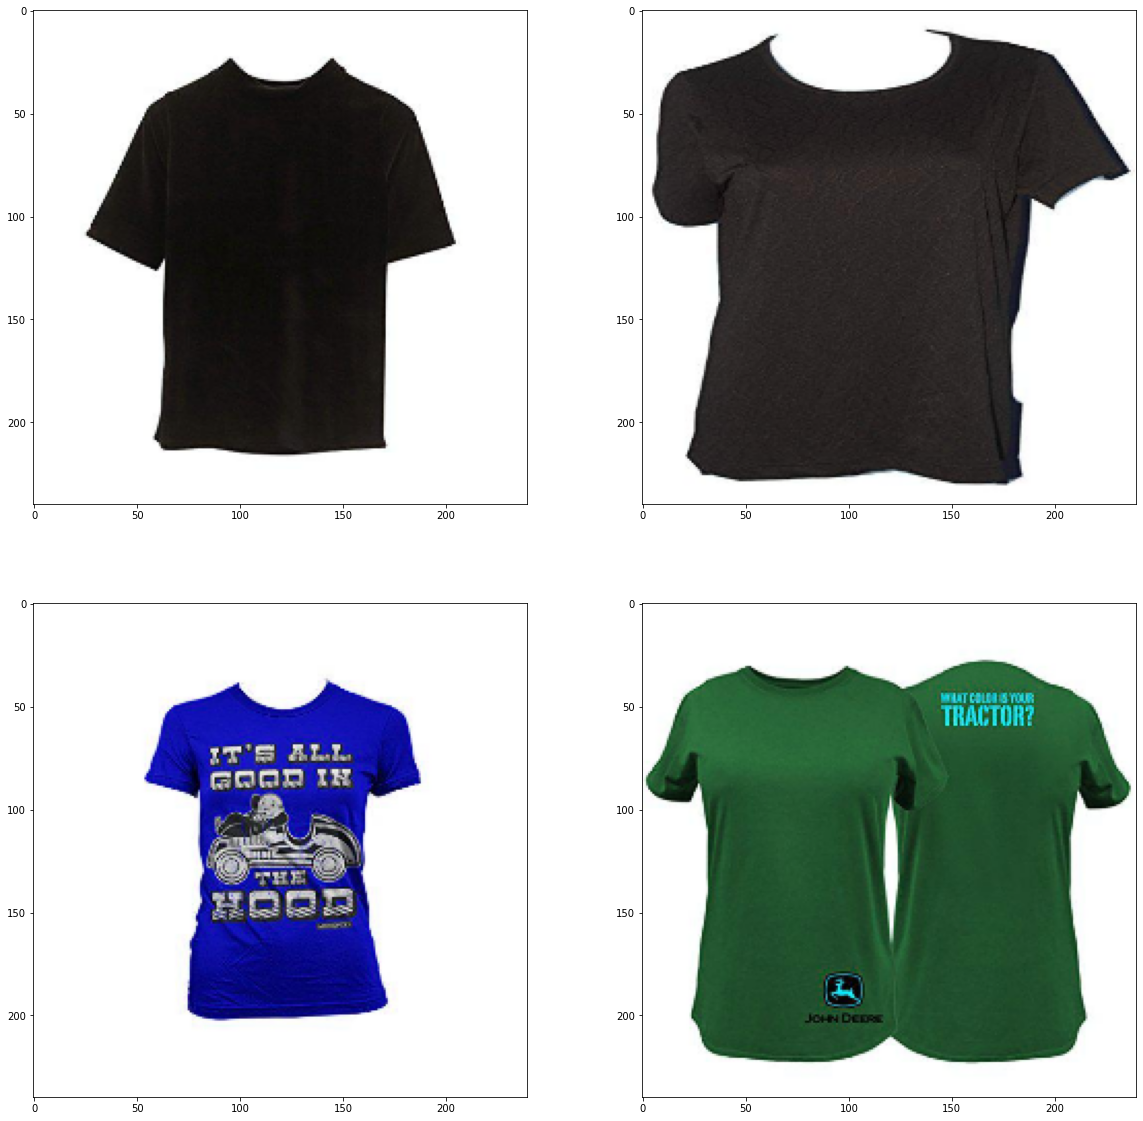

Like = 1 Unlike = 2 Neutral = 3


KeyboardInterrupt: Interrupted by user

In [142]:
def load_url(img):
    return cv2.resize(cv2.imread(img), (240, 240))
def enviorment(img1,img2,img3,img4):
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.imshow(load_url(img1))
    plt.subplot(2,2,2)
    plt.imshow(load_url(img2))
    plt.subplot(2,2,3)
    plt.imshow(load_url(img3))
    plt.subplot(2,2,4)
    plt.imshow(load_url(img4))
    plt.show()
    print('Like = 1 Unlike = 2 Neutral = 3')
    like=[]
    unlike=[]
    neutral=[]
    for i in range(4):
        i1 = input('Image '+str(1+i))
        if(int(i1)==1):
            like.append(i)
        elif(int(i1)==2):
            unlike.append(i)
        else:
            neutral.append(i)
    return like,unlike,neutral
        
            
base = './data/16k_images/'
img = ['','','','']
import random
def random_img():
    img[0] = str(img_5k[random.randint(0,4999)])
    img[1] = str(img_5k[random.randint(0,4999)])
    img[2] = str(img_5k[random.randint(0,4999)])
    img[3] = str(img_5k[random.randint(0,4999)])
    return img
img=random_img()
like,unlike,neutral = enviorment(base+img[0],base+img[1],base+img[2],base+img[3])

indexes = np.arange(0,5000,1)
prev_set_of_images=img_5k.copy()
top_similarity = pd.DataFrame(columns=[])

while(input('goto next yes(1) no(0)')==str(1)):
    start = time.time()
    n_similar = int(len(prev_set_of_images)/2)
    temp = []
    flag=1
    for l in like:
        image_name = img[l]
        curr_index = embedding_df[embedding_df['image']==image_name].index[0]
        closest_image = pd.DataFrame(cosine_similarity_df.loc[curr_index,prev_set_of_images].nlargest(n_similar+1)[1:])
        if(flag==1):
            top_similarity=closest_image
            flag=0
        t=[]
#         for index,sim in closest_image.iterrows():
#             if embedding_df.iloc[index]['image'] in prev_set_of_images:
#             t.append(embedding_df.iloc[index]['image'])
        temp.append(closest_image.index)
    for u in unlike:
        image_name = img[l]
        curr_index = embedding_df[embedding_df['image']==image_name].index[0]
        closest_image = pd.DataFrame(cosine_similarity_df.loc[curr_index].nlargest(10)[1:])
#         if(flag==1):
#             top_similarity=closest_image
#             flag=0
        t=[]
#         for index,sim in closest_image.iterrows():
#             if embedding_df.iloc[index]['image'] in prev_set_of_images:
#             t.append(embedding_df.iloc[index]['image'])
        temp.append(closest_image.index)
        #hidden_embedding+=np.array(embedding_df.drop('image',axis=1).iloc[curr_index])
    for l in neutral:
        image_name = img[l]
        curr_index = embedding_df[embedding_df['image']==image_name].index[0]
        closest_image = pd.DataFrame(cosine_similarity_df.loc[curr_index,prev_set_of_images].nlargest(20)[10:])
        if(flag==1):
            top_similarity=closest_image
            flag=0
        t=[]
#         for index,sim in closest_image.iterrows():
#             if embedding_df.iloc[index]['image'] in prev_set_of_images:
#             t.append(embedding_df.iloc[index]['image'])
        temp.append(closest_image.index)
    #checking common image into above likes images
    j=0
    ans = []#prev_set_of_images
    for l in like:
        ans = set(temp[j]).union(set(ans))
        j+=1
    for l in unlike:
        prev_set_of_images = set(prev_set_of_images).difference(set(temp[j]))
        j+=1
    for l in neutral:
        ans = set(temp[j]).union(set(ans))
        j+=1
    if(flag==0 and len(like)!=0):
        prev_set_of_images = ans
    if(len(like)==0):
        prev_set_of_images = list(prev_set_of_images) + list(ans)
        
    end=time.time()
    print("-----------------------------------------------------------------------")
    print(f"Recommended Product {len(prev_set_of_images)}   compute time {end-start}")
    if(flag==1):
        img=random_img()
        like,unlike,neutral = enviorment(base+img[0],base+img[1],base+img[2],base+str(list(prev_set_of_images)[random.randint(0,len(prev_set_of_images)-1)]))
        continue
    j=0
    print(f'top images {len(top_similarity)}')
    for index in top_similarity.index:
#         if(index in prev_set_of_images):
        img[j] = index #list(top_similarity.index)[max(int(len(top_similarity.index)*(j+2)/100),j)]
        j+=1
        if(j==3):
            like,unlike,neutral = enviorment(base+img[0],base+img[1],base+top_similarity.index[-1],base+str(list(prev_set_of_images)[random.randint(0,len(prev_set_of_images)-1)]))
            break
    

#             similarity = np.round(imgs.iloc[0],3)
#             show_img(similar_image_name,str(similar_image_name)+' nSimilarity : '+str(similarity) + ' Index : '+str(index))

    

# Based on previous liked image we are doing linear combination of those embeddings and find similarity from them

In [ ]:
First 2 images using finding cosine similarity(top 3 simiarity).
3rd image we are keep track of all like images(hidden_embedding) and finding cosine similarity based on that
4th one is random image from Narrow-down-set-of-images.

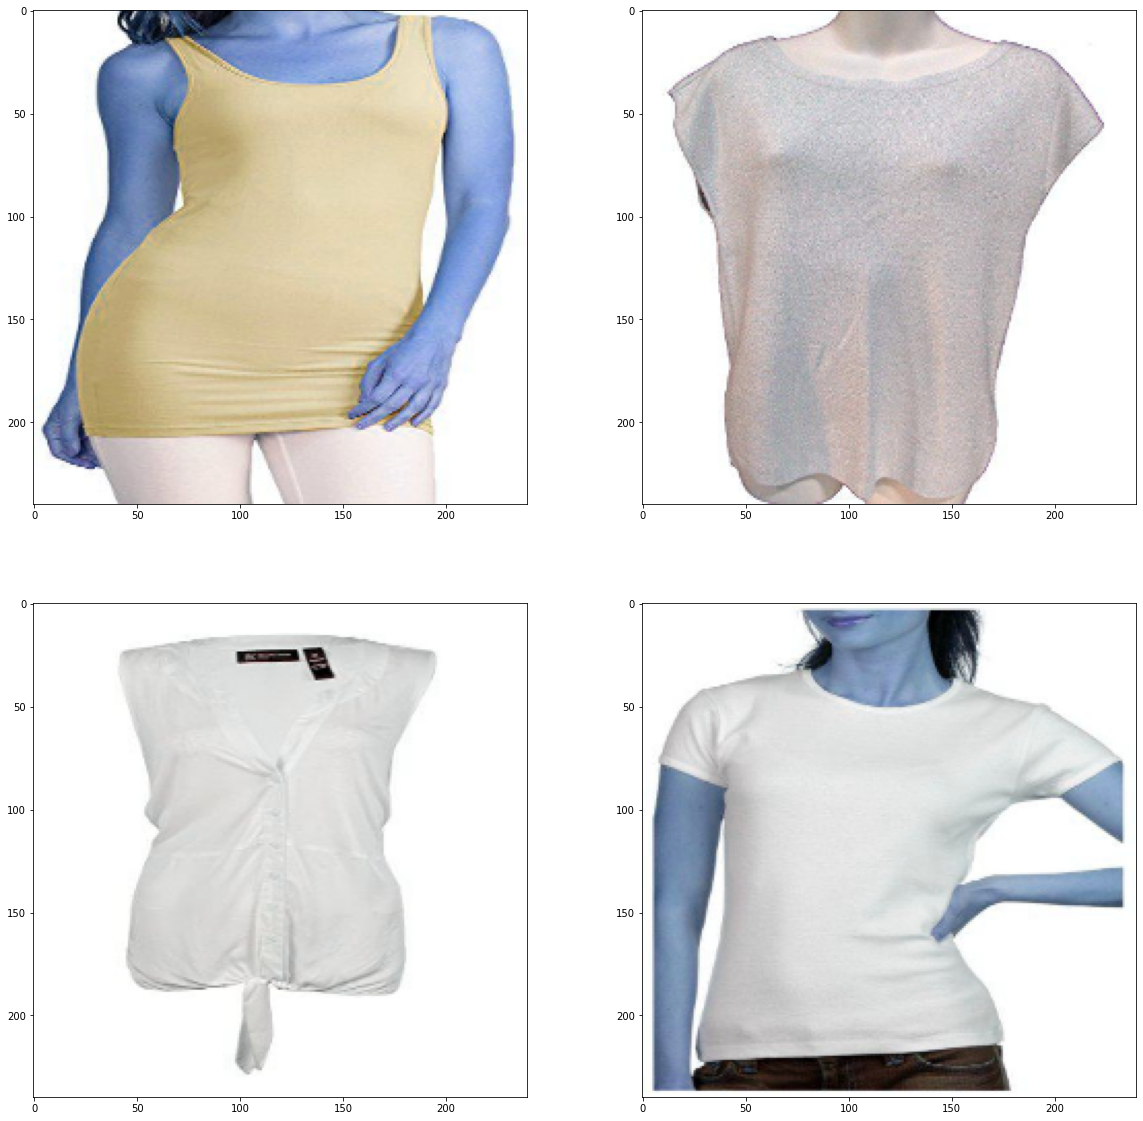

Like = 1 Unlike = 2 Neutral = 3
Image 12
Image 22
Image 31
Image 42
goto next yes(1) no(0)1
-----------------------------------------------------------------------
Recommended Product 2500   compute time 0.03706789016723633


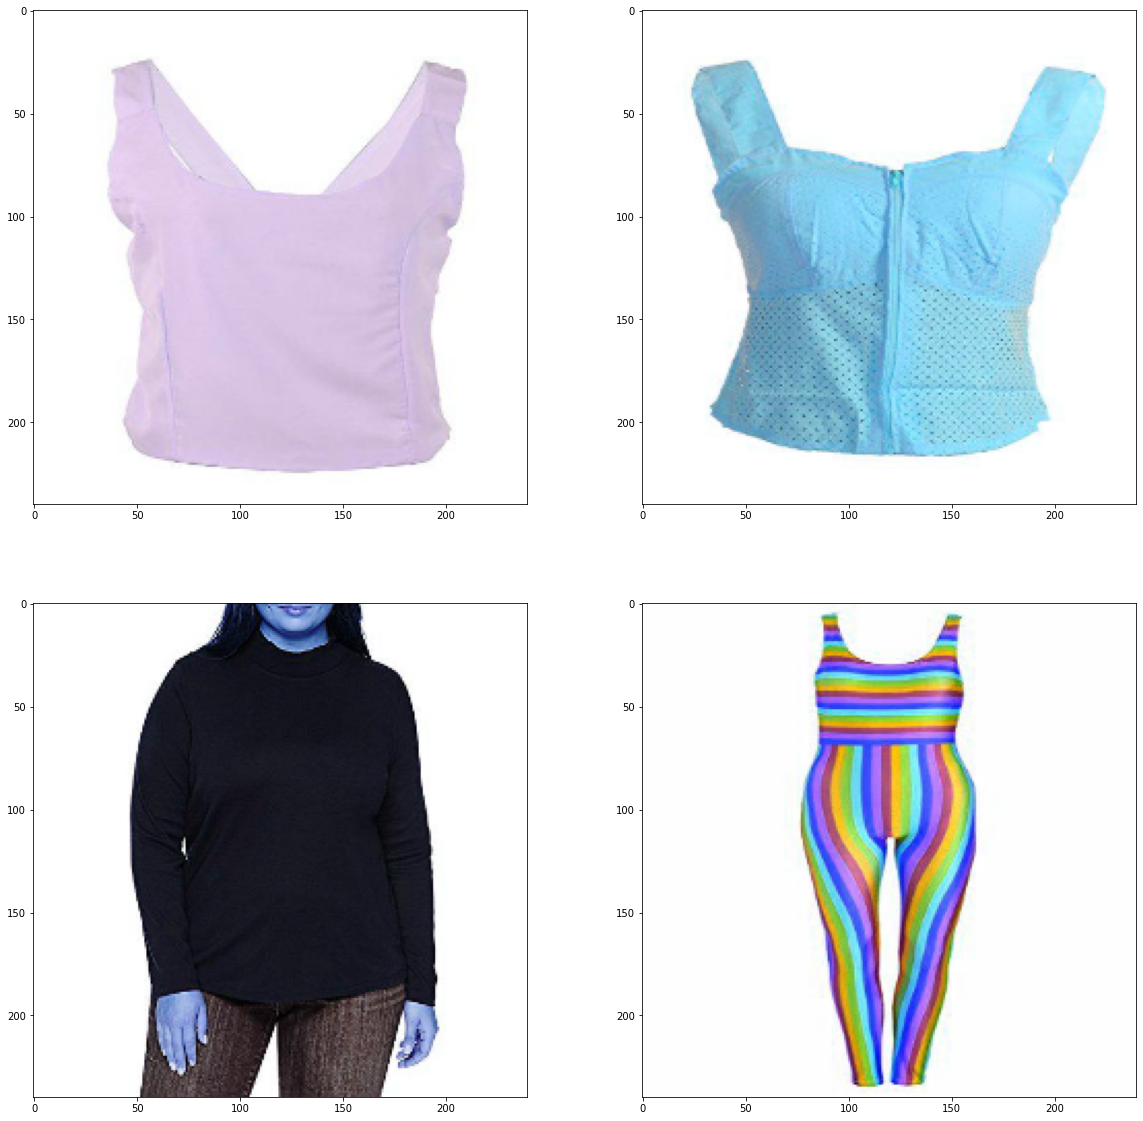

Like = 1 Unlike = 2 Neutral = 3
Image 12
Image 22
Image 31
Image 42
goto next yes(1) no(0)1
-----------------------------------------------------------------------
Recommended Product 1250   compute time 0.026484966278076172


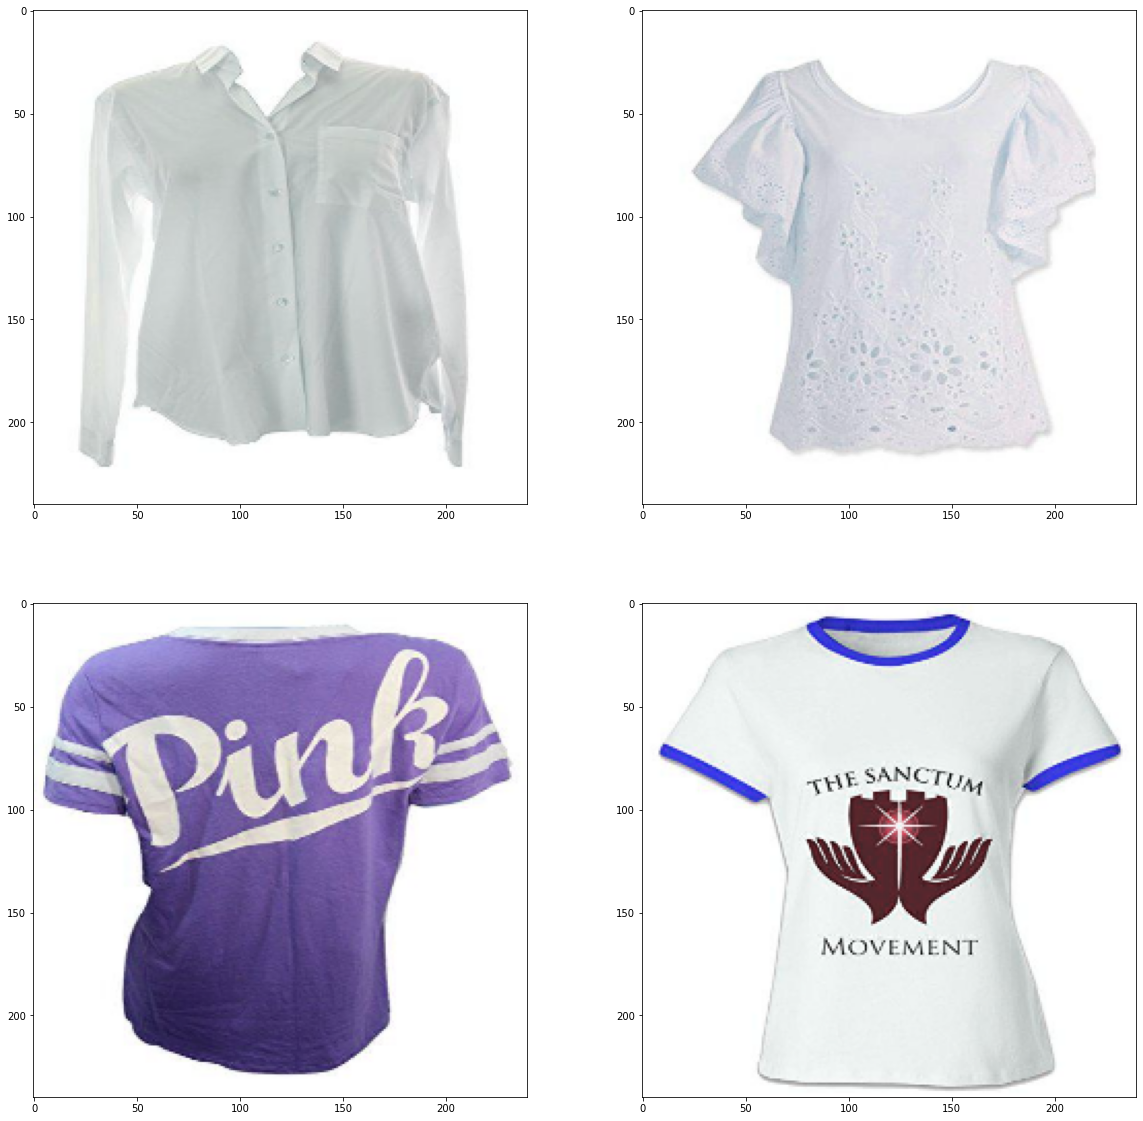

Like = 1 Unlike = 2 Neutral = 3


KeyboardInterrupt: Interrupted by user

In [135]:
def load_url(img):
    return cv2.resize(cv2.imread(img), (240, 240))
def enviorment(img1,img2,img3,img4):
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.imshow(load_url(img1))
    plt.subplot(2,2,2)
    plt.imshow(load_url(img2))
    plt.subplot(2,2,3)
    plt.imshow(load_url(img3))
    plt.subplot(2,2,4)
    plt.imshow(load_url(img4))
    plt.show()
    print('Like = 1 Unlike = 2 Neutral = 3')
    like=[]
    unlike=[]
    neutral=[]
    for i in range(4):
        i1 = input('Image '+str(1+i))
        if(int(i1)==1):
            like.append(i)
        elif(int(i1)==2):
            unlike.append(i)
        else:
            neutral.append(i)
    return like,unlike,neutral
        
def findcosinesimilarity(prev_set_of_images,hidden_embedding):
    res = 0
#     print(f'hidden {len(hidden_embedding)}  {len(hidden_embedding)}')
    for i in range(5000):
        n = i#random.randint(0,4999)
        if img_5k[n] in prev_set_of_images:
            continue
        temp = cosine_similarity([hidden_embedding,embedding_5k_copy[n,0,:]])[0,1]
        if(temp>res):
            res = n
    return img_5k[res]
base = './data/16k_images/'
img = ['','','','']
import random
def random_img():
    img[0] = str(img_5k[random.randint(0,4999)])
    img[1] = str(img_5k[random.randint(0,4999)])
    img[2] = str(img_5k[random.randint(0,4999)])
    img[3] = str(img_5k[random.randint(0,4999)])
    return img
img=random_img()
like,unlike,neutral = enviorment(base+img[0],base+img[1],base+img[2],base+img[3])

indexes = np.arange(0,5000,1)
prev_set_of_images=img_5k.copy()
top_similarity = pd.DataFrame(columns=[])

while(input('goto next yes(1) no(0)')==str(1)):
    start = time.time()
    n_similar = int(len(prev_set_of_images)/2)
    temp = []
    flag=1
    hidden_embedding = [0.0]*2048
    for l in like:
        image_name = img[l]
        curr_index = embedding_df[embedding_df['image']==image_name].index[0]
        hidden_embedding = 0.67*np.array(hidden_embedding) + 0.33*np.array(embedding_5k_copy[curr_index])
        hidden_embedding = hidden_embedding.reshape(2048)
        closest_image = pd.DataFrame(cosine_similarity_df.loc[curr_index,prev_set_of_images].nlargest(n_similar+1)[1:])
        if(flag==1):
            top_similarity=closest_image
            flag=0
        t=[]
#         for index,sim in closest_image.iterrows():
#             if embedding_df.iloc[index]['image'] in prev_set_of_images:
#             t.append(embedding_df.iloc[index]['image'])
        temp.append(closest_image.index)
    for u in unlike:
        image_name = img[l]
        curr_index = embedding_df[embedding_df['image']==image_name].index[0]
        closest_image = pd.DataFrame(cosine_similarity_df.loc[curr_index].nlargest(10)[1:])
#         if(flag==1):
#             top_similarity=closest_image
#             flag=0
        t=[]
#         for index,sim in closest_image.iterrows():
#             if embedding_df.iloc[index]['image'] in prev_set_of_images:
#             t.append(embedding_df.iloc[index]['image'])
        temp.append(closest_image.index)
        #hidden_embedding+=np.array(embedding_df.drop('image',axis=1).iloc[curr_index])
    for l in neutral:
        image_name = img[l]
        curr_index = embedding_df[embedding_df['image']==image_name].index[0]
        closest_image = pd.DataFrame(cosine_similarity_df.loc[curr_index,prev_set_of_images].nlargest(20)[10:])
        if(flag==1):
            top_similarity=closest_image
            flag=0
        t=[]
#         for index,sim in closest_image.iterrows():
#             if embedding_df.iloc[index]['image'] in prev_set_of_images:
#             t.append(embedding_df.iloc[index]['image'])
        temp.append(closest_image.index)
    #checking common image into above likes images
    j=0
    ans = []#prev_set_of_images
    for l in like:
        ans = set(temp[j]).union(set(ans))
        j+=1
    for l in unlike:
        prev_set_of_images = set(prev_set_of_images).difference(set(temp[j]))
        j+=1
    for l in neutral:
        ans = set(temp[j]).union(set(ans))
        j+=1
    if(flag==0 and len(like)!=0):
        prev_set_of_images = ans
    if(len(like)==0):
        prev_set_of_images = list(prev_set_of_images) + list(ans)
        
    end=time.time()
    print("-----------------------------------------------------------------------")
    print(f"Recommended Product {len(prev_set_of_images)}   compute time {end-start}")
    based_on_previous = findcosinesimilarity(prev_set_of_images,hidden_embedding)
    if(flag==1):
        img=random_img()
        like,unlike,neutral = enviorment(base+img[0],base+img[1],base+based_on_previous,base+str(list(prev_set_of_images)[random.randint(0,len(prev_set_of_images)-1)]))
        continue
    j=0
#     print(f'top images {len(top_similarity)}')
    for index in top_similarity.index:
#         if(index in prev_set_of_images):
        img[j] = index
        j+=1
        if(j==3):
            like,unlike,neutral = enviorment(base+img[0],base+img[1],base+based_on_previous,base+str(list(prev_set_of_images)[random.randint(0,len(prev_set_of_images)-1)]))
            break
    

#             similarity = np.round(imgs.iloc[0],3)
#             show_img(similar_image_name,str(similar_image_name)+' nSimilarity : '+str(similarity) + ' Index : '+str(index))

    